In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the dataset
try:
    # Try to load from local file first
    df = pd.read_csv('Online Retail.csv', encoding='ISO-8859-1')
except:
    try:
        # If that fails, try from UCI repository URL
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
        df = pd.read_excel(url)
    except:
        print("Please download the dataset and ensure it's in your working directory")
        # For demonstration, I'll create a sample from the provided snippet
        # In practice, you should use the actual dataset

In [5]:
# Data preprocessing
def preprocess_data(df):
    """Clean and preprocess the retail data"""
    # Create a copy
    data = df.copy()

    # Remove rows with missing CustomerID
    data = data[data['CustomerID'].notna()]

    # Convert CustomerID to integer
    data['CustomerID'] = data['CustomerID'].astype(int)

    # Convert InvoiceDate to datetime
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

    # Calculate total amount
    data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

    # Remove negative quantities and prices (returns)
    data = data[data['Quantity'] > 0]
    data = data[data['UnitPrice'] > 0]

    return data

In [6]:
# Apply preprocessing
df_clean = preprocess_data(df)

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"Number of unique customers: {df_clean['CustomerID'].nunique()}")
print(f"Date range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")

# RFM Analysis
def calculate_rfm(data, snapshot_date=None):
    """Calculate RFM metrics for each customer"""
    if snapshot_date is None:
        snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

    # Group by customer
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'TotalAmount': 'sum'     # Monetary
    }).reset_index()

    # Rename columns
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

    return rfm

Dataset shape after cleaning: (397884, 9)
Number of unique customers: 4338
Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [7]:
# Calculate RFM metrics
rfm_df = calculate_rfm(df_clean)
print("\nRFM Metrics Summary:")
print(rfm_df.describe())

# Assign RFM scores - FIXED VERSION
def assign_rfm_scores(rfm_df):
    """Assign scores from 1-4 for each RFM metric (4 is best)"""
    rfm_scores = rfm_df.copy()

    # Recency: lower values are better (more recent)
    # Use qcut with duplicates='drop' to handle duplicate bin edges
    rfm_scores['R_Score'] = pd.qcut(rfm_scores['Recency'], 4, labels=[4, 3, 2, 1], duplicates='drop')

    # Frequency: higher values are better
    # For frequency, we need to handle cases where there are duplicate bin edges
    try:
        rfm_scores['F_Score'] = pd.qcut(rfm_scores['Frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop')
    except ValueError:
        # If qcut fails, use custom bins based on percentiles
        freq_percentiles = rfm_scores['Frequency'].quantile([0, 0.25, 0.5, 0.75, 1.0]).unique()
        if len(freq_percentiles) < 5:
            # If we still don't have enough unique percentiles, use rank-based approach
            rfm_scores['F_Score'] = pd.qcut(rfm_scores['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
        else:
            rfm_scores['F_Score'] = pd.cut(rfm_scores['Frequency'], bins=freq_percentiles, labels=[1, 2, 3, 4], include_lowest=True)

    # Monetary: higher values are better
    try:
        rfm_scores['M_Score'] = pd.qcut(rfm_scores['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')
    except ValueError:
        # If qcut fails, use custom bins based on percentiles
        monetary_percentiles = rfm_scores['Monetary'].quantile([0, 0.25, 0.5, 0.75, 1.0]).unique()
        if len(monetary_percentiles) < 5:
            # If we still don't have enough unique percentiles, use rank-based approach
            rfm_scores['M_Score'] = pd.qcut(rfm_scores['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])
        else:
            rfm_scores['M_Score'] = pd.cut(rfm_scores['Monetary'], bins=monetary_percentiles, labels=[1, 2, 3, 4], include_lowest=True)

    # Convert to numeric (handle categorical if needed)
    rfm_scores['R_Score'] = rfm_scores['R_Score'].astype(int)
    rfm_scores['F_Score'] = rfm_scores['F_Score'].astype(int)
    rfm_scores['M_Score'] = rfm_scores['M_Score'].astype(int)

    # Create RFM segment
    rfm_scores['RFM_Segment'] = rfm_scores['R_Score'].astype(str) + rfm_scores['F_Score'].astype(str) + rfm_scores['M_Score'].astype(str)

    # Create RFM score (sum of all three)
    rfm_scores['RFM_Score'] = rfm_scores['R_Score'] + rfm_scores['F_Score'] + rfm_scores['M_Score']

    return rfm_scores


RFM Metrics Summary:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


In [8]:
# Alternative robust RFM scoring method
def assign_rfm_scores_robust(rfm_df):
    """More robust RFM scoring that handles duplicate values better"""
    rfm_scores = rfm_df.copy()

    # Method 1: Use rank-based percentiles
    rfm_scores['R_Score'] = pd.qcut(rfm_scores['Recency'].rank(method='first'), 4, labels=[4, 3, 2, 1])
    rfm_scores['F_Score'] = pd.qcut(rfm_scores['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
    rfm_scores['M_Score'] = pd.qcut(rfm_scores['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])

    # Convert to numeric
    rfm_scores['R_Score'] = rfm_scores['R_Score'].astype(int)
    rfm_scores['F_Score'] = rfm_scores['F_Score'].astype(int)
    rfm_scores['M_Score'] = rfm_scores['M_Score'].astype(int)

    # Create RFM segment and score
    rfm_scores['RFM_Segment'] = rfm_scores['R_Score'].astype(str) + rfm_scores['F_Score'].astype(str) + rfm_scores['M_Score'].astype(str)
    rfm_scores['RFM_Score'] = rfm_scores['R_Score'] + rfm_scores['F_Score'] + rfm_scores['M_Score']

    return rfm_scores

# Use the robust method to avoid the bin edges error
rfm_scores = assign_rfm_scores_robust(rfm_df)

# Customer segmentation based on RFM scores
def segment_customers(rfm_scores):
    """Segment customers based on RFM scores"""
    segments = rfm_scores.copy()

    # Define segments based on RFM scores
    conditions = [
        (segments['RFM_Score'] >= 11),
        (segments['RFM_Score'] >= 9) & (segments['RFM_Score'] <= 10),
        (segments['RFM_Score'] >= 7) & (segments['RFM_Score'] <= 8),
        (segments['RFM_Score'] >= 5) & (segments['RFM_Score'] <= 6),
        (segments['RFM_Score'] <= 4)
    ]

    choices = ['Champions', 'Loyal Customers', 'Potential Loyalists', 'At Risk', 'Lost Customers']

    segments['Segment'] = np.select(conditions, choices, default='Needs Attention')

    # Alternative segmentation based on individual scores
    def detailed_segmentation(row):
        r, f, m = row['R_Score'], row['F_Score'], row['M_Score']

        if r == 4 and f == 4 and m == 4:
            return 'Best Customers'
        elif r == 4 and f >= 3:
            return 'Loyal Customers'
        elif r >= 3 and f >= 3:
            return 'Potential Loyalists'
        elif r >= 3 and f <= 2:
            return 'New Customers'
        elif r == 2:
            return 'At Risk'
        elif r == 1:
            return 'Lost Customers'
        else:
            return 'Needs Attention'

    segments['Detailed_Segment'] = segments.apply(detailed_segmentation, axis=1)

    return segments

In [9]:
segmented_customers = segment_customers(rfm_scores)

In [10]:
# Analysis results
print("\nCustomer Segmentation Results:")
segment_summary = segmented_customers['Detailed_Segment'].value_counts()
print(segment_summary)


Customer Segmentation Results:
Detailed_Segment
Lost Customers         1085
At Risk                1084
New Customers           655
Potential Loyalists     650
Best Customers          478
Loyal Customers         386
Name: count, dtype: int64


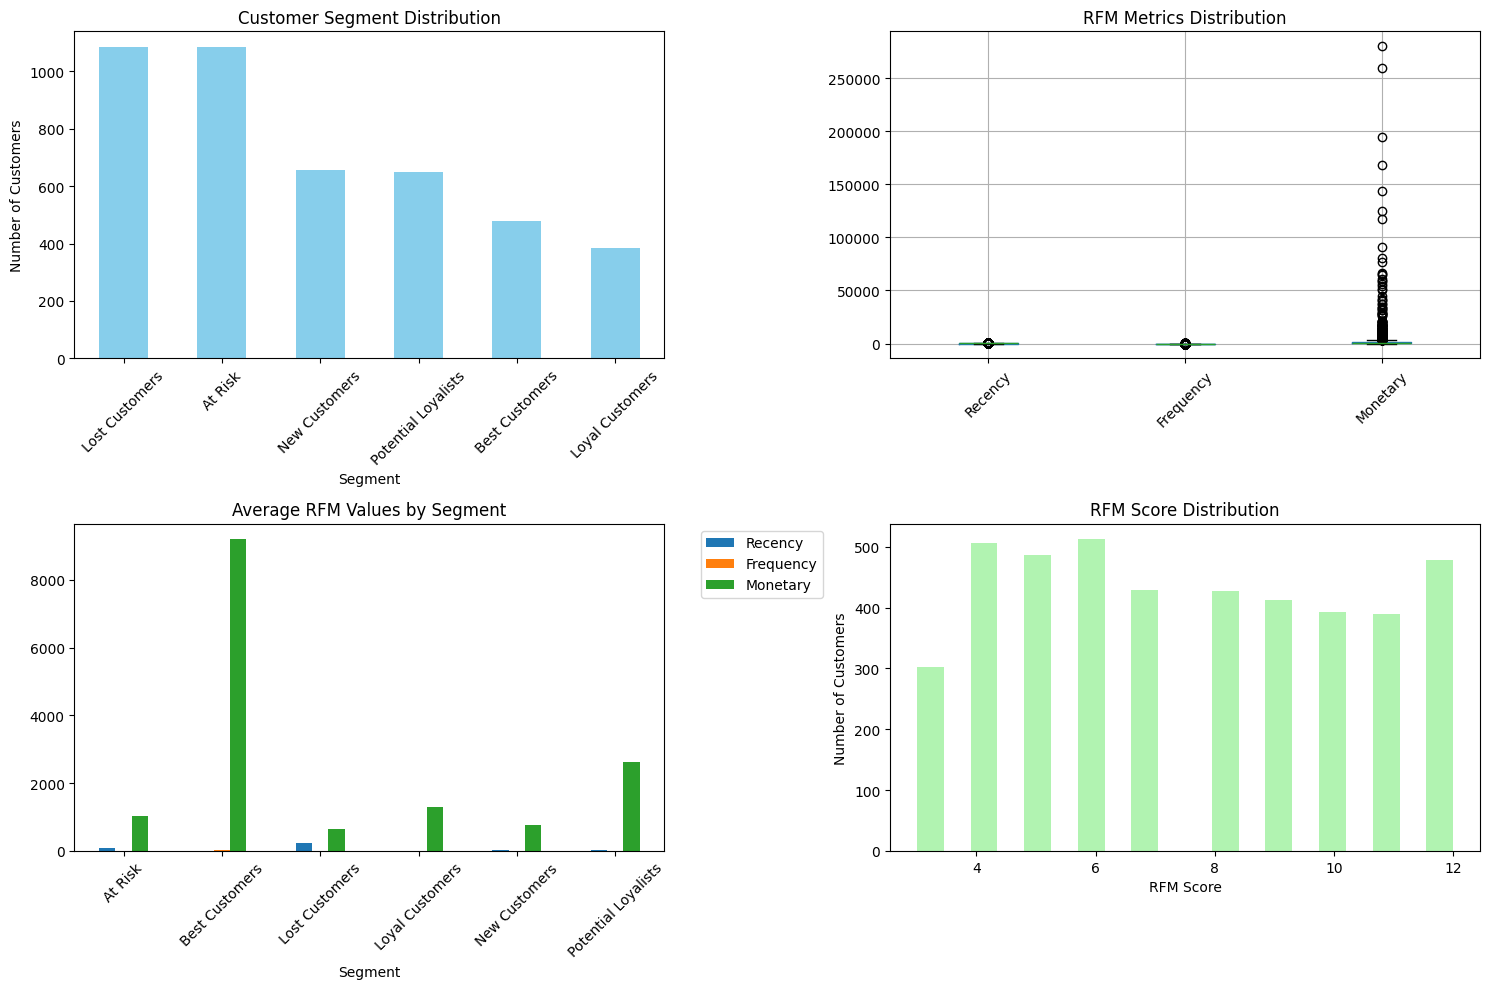

In [11]:
# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Segment distribution
plt.subplot(2, 2, 1)
segment_summary.plot(kind='bar', color='skyblue')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# Plot 2: RFM distribution
plt.subplot(2, 2, 2)
rfm_metrics = ['Recency', 'Frequency', 'Monetary']
rfm_df[rfm_metrics].boxplot()
plt.title('RFM Metrics Distribution')
plt.xticks(rotation=45)

# Plot 3: Segment characteristics
plt.subplot(2, 2, 3)
segment_means = segmented_customers.groupby('Detailed_Segment')[['Recency', 'Frequency', 'Monetary']].mean()
segment_means.plot(kind='bar', ax=plt.gca())
plt.title('Average RFM Values by Segment')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: RFM score distribution
plt.subplot(2, 2, 4)
plt.hist(segmented_customers['RFM_Score'], bins=20, color='lightgreen', alpha=0.7)
plt.title('RFM Score Distribution')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [12]:
# Marketing recommendations for each segment
def get_marketing_recommendations(segment):
    """Provide marketing recommendations for each customer segment"""
    recommendations = {
        'Best Customers': [
            "Exclusive loyalty rewards",
            "Early access to new products",
            "Premium customer service",
            "Personalized offers"
        ],
        'Loyal Customers': [
            "Loyalty program benefits",
            "Special discounts on favorite products",
            "Birthday/anniversary rewards",
            "Referral program incentives"
        ],
        'Potential Loyalists': [
            "Upsell/cross-sell opportunities",
            "Bundled product offers",
            "Frequency-based rewards",
            "Personalized recommendations"
        ],
        'New Customers': [
            "Welcome series emails",
            "First-purchase follow-up",
            "Educational content about products",
            "Introduction to loyalty program"
        ],
        'At Risk': [
            "Win-back campaigns",
            "Special reactivation offers",
            "We miss you emails",
            "Limited-time discounts"
        ],
        'Lost Customers': [
            "Re-engagement surveys",
            "Significant discount offers",
            "Product recall campaigns",
            "New feature announcements"
        ],
        'Needs Attention': [
            "General marketing communication",
            "Seasonal promotions",
            "Newsletter subscriptions",
            "Social media engagement"
        ]
    }

    return recommendations.get(segment, ["General marketing communication"])

In [13]:
# Display recommendations for each segment
print("\n" + "="*50)
print("MARKETING RECOMMENDATIONS BY SEGMENT")
print("="*50)

for segment in segmented_customers['Detailed_Segment'].unique():
    segment_customers = segmented_customers[segmented_customers['Detailed_Segment'] == segment]
    segment_size = len(segment_customers)
    avg_recency = segment_customers['Recency'].mean()
    avg_frequency = segment_customers['Frequency'].mean()
    avg_monetary = segment_customers['Monetary'].mean()

    print(f"\n{segment.upper()} (Size: {segment_size} customers)")
    print(f"Avg Recency: {avg_recency:.1f} days | Avg Frequency: {avg_frequency:.1f} | Avg Monetary: £{avg_monetary:.2f}")
    print("Recommended Actions:")

    recommendations = get_marketing_recommendations(segment)
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")


MARKETING RECOMMENDATIONS BY SEGMENT

LOST CUSTOMERS (Size: 1085 customers)
Avg Recency: 246.9 days | Avg Frequency: 1.6 | Avg Monetary: £651.91
Recommended Actions:
  1. Re-engagement surveys
  2. Significant discount offers
  3. Product recall campaigns
  4. New feature announcements

BEST CUSTOMERS (Size: 478 customers)
Avg Recency: 7.2 days | Avg Frequency: 15.7 | Avg Monetary: £9190.88
Recommended Actions:
  1. Exclusive loyalty rewards
  2. Early access to new products
  3. Premium customer service
  4. Personalized offers

AT RISK (Size: 1084 customers)
Avg Recency: 83.7 days | Avg Frequency: 2.6 | Avg Monetary: £1033.92
Recommended Actions:
  1. Win-back campaigns
  2. Special reactivation offers
  3. We miss you emails
  4. Limited-time discounts

NEW CUSTOMERS (Size: 655 customers)
Avg Recency: 24.9 days | Avg Frequency: 1.5 | Avg Monetary: £757.57
Recommended Actions:
  1. Welcome series emails
  2. First-purchase follow-up
  3. Educational content about products
  4. Intro

In [14]:
# Additional insights
print("\n" + "="*50)
print("KEY INSIGHTS")
print("="*50)

# Top customers
top_customers = segmented_customers.nlargest(5, 'Monetary')
print(f"\nTop 5 Customers by Revenue:")
for _, customer in top_customers.iterrows():
    print(f"Customer {customer['CustomerID']}: £{customer['Monetary']:.2f}")

# Segment with highest potential
potential_segment = segmented_customers[segmented_customers['Detailed_Segment'] == 'Potential Loyalists']
if len(potential_segment) > 0:
    print(f"\nPotential Loyalists segment has {len(potential_segment)} customers")
    print(f"Average revenue per customer: £{potential_segment['Monetary'].mean():.2f}")

# Save results
segmented_customers.to_csv('customer_segmentation_rfm.csv', index=False)
print(f"\nResults saved to 'customer_segmentation_rfm.csv'")

# Display sample of segmented customers
print(f"\nSample of Segmented Customers:")
print(segmented_customers[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Detailed_Segment']].head(10))

# Additional analysis: RFM score distribution by segment
print(f"\nRFM Score Statistics by Segment:")
rfm_score_stats = segmented_customers.groupby('Detailed_Segment')['RFM_Score'].agg(['mean', 'min', 'max']).round(2)
print(rfm_score_stats)


KEY INSIGHTS

Top 5 Customers by Revenue:
Customer 14646: £280206.02
Customer 18102: £259657.30
Customer 17450: £194550.79
Customer 16446: £168472.50
Customer 14911: £143825.06

Potential Loyalists segment has 650 customers
Average revenue per customer: £2614.52

Results saved to 'customer_segmentation_rfm.csv'

Sample of Segmented Customers:
   CustomerID  Recency  Frequency  Monetary  RFM_Score     Detailed_Segment
0       12346      326          1  77183.60          6       Lost Customers
1       12347        2          7   4310.00         12       Best Customers
2       12348       75          4   1797.24          9              At Risk
3       12349       19          1   1757.55          8        New Customers
4       12350      310          1    334.40          4       Lost Customers
5       12352       36          8   2506.04         11  Potential Loyalists
6       12353      204          1     89.00          3       Lost Customers
7       12354      232          1   1079.40   